In [1]:
projectdir = "C:/Users/ArmanAngaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/"
cd(projectdir)
using Pkg; Pkg.activate(projectdir)

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, LsqFit, Pipe, ProgressMeter, StatsPlots, Distributed, Roots
pyplot()

try 
    Turnover
catch e
    include(projectdir*"Turnover/Turnover.jl")
    include(projectdir*"Turnover/test.jl")
    using .Turnover
end
try SeqDataFormatting
catch e
    include(projectdir*"experimental_data/SeqDataFormatting.jl")
    import .SeqDataFormatting
end

import TumorGrowth
include(projectdir*"distribution_functions.jl")
include(projectdir*"simulated_tumors/path_format.jl")
include(projectdir*"Turnover/utility.jl")
include(projectdir*"SamplingAnalysis/plot_funcs.jl")
plot(size=(1,1))

  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`

Test Summary:             | Pass  Total


Applying turnover methods |    7      7


# Load data

In [3]:
tumorinfo = dir_info_mutations(projectdir*"/simulated_tumors/2d/bulk/")
filter!(x-> x.N == 10000 && x.μ == 0.2 && x.d in 0.:0.2:0.8, tumorinfo)
for x in groupby(tumorinfo, :d)
    print("d=",first(x.d), ": ", nrow(x), ", ")
end

d=0.0: 10, d=0.2: 34, d=0.4: 34, d=0.6: 42, d=0.8: 33, 

In [4]:
# filter!(r->r.N==40_000 && r.ρ == Inf && r.d in 0.0:0.2:0.8 && r.μ == 0.3 && r.dim==3, tumorinfo)
filter!(r->r.N==10_000 && r.ρ == Inf && r.d in 0.0:0.2:0.8 && r.μ == 0.2 && r.dim==2, tumorinfo)
tumorinfo.tumor = @showprogress pmap(TumorGrowth.data_import, tumorinfo.tumorpath)
tumorinfo.mutations = @showprogress pmap(TumorGrowth.data_import, tumorinfo.mutationspath)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:09:15
Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


# Full single-cell set

### use frequency

In [5]:
function infer_params_Ncorrect( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
    dfits = []
    mufits = []

    @showprogress for i in 1:nrow(tumorinfo)
        b, mu = tumorinfo.b[i], tumorinfo.μ[i]
        W_a, W_o = Wa[i], Wo[i]
        
        d_solve, mu_solve = 1., missing
        try
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; N= Nthresh_orph/(1-x) )) - W_a, 0.01, 0.99) * b
            mu_solve = fzero(x -> min(1., Turnover.W_estranged(d_solve; b=b, μ=x, 
                            T=log(Nthresh_estr* b/(b-d_solve)^2)))- W_o, 0.01, 0.99)
            catch e
        end

        push!(dfits, d_solve)
        push!(mufits, mu_solve)

        sleep(0.01)
    end
    return (ds = tumorinfo.d, dfits = dfits, mufits = mufits)
end

infer_params_Ncorrect (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


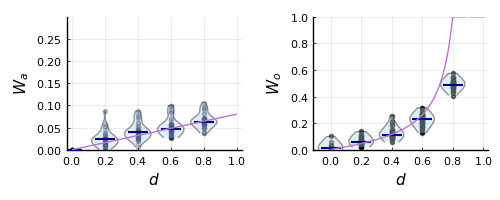

In [56]:
Nthresh = 500
ds, Wa, Wo = get_turnover(tumorinfo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh,
    tumor_sample_func = df -> df)
plot_turnover_violin(ds, Wa, Wo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


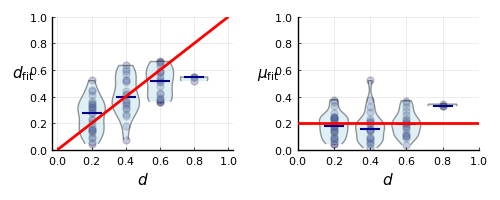

In [9]:
ds, dfits, mufits = infer_params_Ncorrect( tumorinfo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, Wa, Wo)
mask = .!ismissing.(mufits)
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


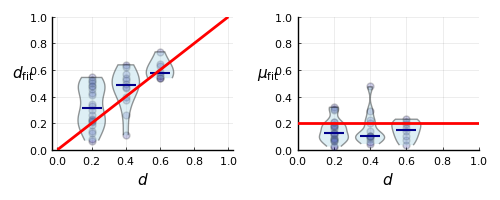

In [9]:
ds, dfits, mufits = infer_params_Ncorrect( tumorinfo; Nthresh_orph=10_000, Nthresh_estr=10_000, Wa, Wo)
mask = .!ismissing.(mufits)
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


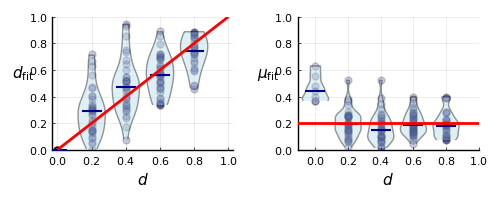

In [57]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, Wa, Wo)
mask = .!ismissing.(mufits)
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


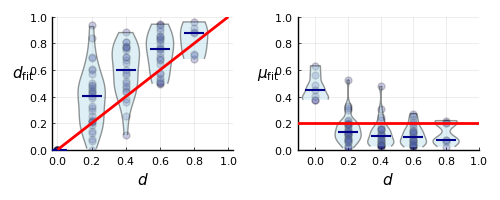

In [6]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=10_000, Nthresh_estr=10_000, Wa, Wo)
mask = .!ismissing.(mufits)
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

### use known tumor size `N` at birth

In [11]:
function infer_params_Ncorrect( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
    dfits = []
    mufits = []

    @showprogress for i in 1:nrow(tumorinfo)
        b, mu = tumorinfo.b[i], tumorinfo.μ[i]
        W_a, W_o = Wa[i], Wo[i]
        
        d_solve, mu_solve = 1., missing
        try
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; N= Nthresh_orph*(1-x) )) - W_a, 0.01, 0.99) * b
            mu_solve = fzero(x -> min(1., Turnover.W_estranged(d_solve; b=b, μ=x, 
                            T=log(Nthresh_estr/b)))- W_o, 0.01, 0.99)
            catch e
        end

        push!(dfits, d_solve)
        push!(mufits, mu_solve)

        sleep(0.01)
    end
    return (ds = tumorinfo.d, dfits = dfits, mufits = mufits)
end

infer_params_Ncorrect (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


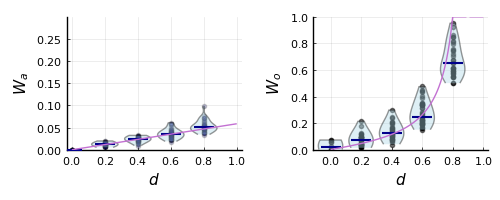

In [12]:
Nthresh_orph , Nthresh_estr = 5000, 500
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, Nthresh_orph, Nthresh_estr,
    tumor_sample_func = df -> df)
mask = .!(isnan.(Wo))
ds, Wa, Wo = ds[mask], Wa[mask], Wo[mask]
plot_turnover_violin(ds, Wa, Wo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


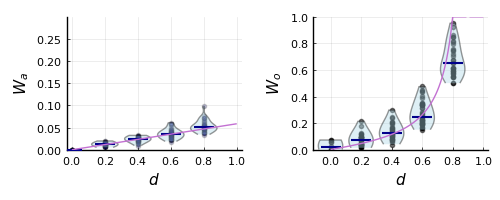

In [31]:
Nthresh_orph , Nthresh_estr = 5000, 500
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, Nthresh_orph, Nthresh_estr,
    tumor_sample_func = df -> df)
mask = .!(isnan.(Wo))
ds, Wa, Wo = ds[mask], Wa[mask], Wo[mask]
plot_turnover_violin(ds, Wa, Wo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


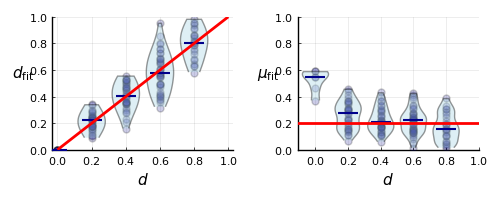

In [14]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo)
mask = .!ismissing.(mufits)
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


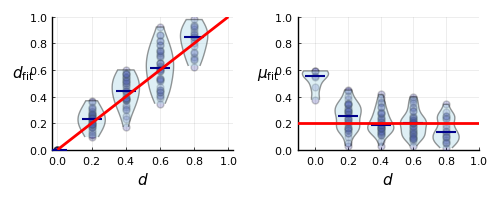

In [15]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=10_000, Nthresh_estr=10_000, Wa, Wo)
mask = .!ismissing.(mufits)
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


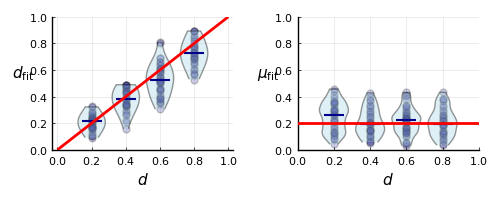

In [16]:
ds, dfits, mufits = infer_params_Ncorrect( tumorinfo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo)
mask = .!ismissing.(mufits)
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


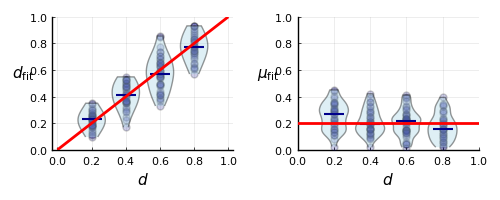

In [17]:
ds, dfits, mufits = infer_params_Ncorrect( tumorinfo; Nthresh_orph=10_000, Nthresh_estr=10_000, Wa, Wo)
mask = .!ismissing.(mufits)
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


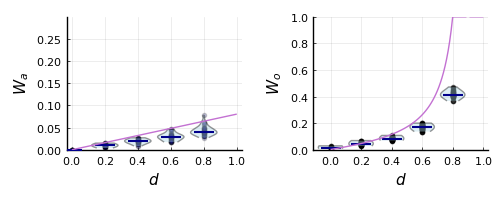

In [55]:
Nthresh_orph , Nthresh_estr = 7000, 5000
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, Nthresh_orph, Nthresh_estr,
    tumor_sample_func = df -> df)
mask = .!(isnan.(Wo))
ds, Wa, Wo = ds[mask], Wa[mask], Wo[mask]
plot_turnover_violin(ds, Wa, Wo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, mu=0.2, size=(500,200))

### use known time `T` at birth

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


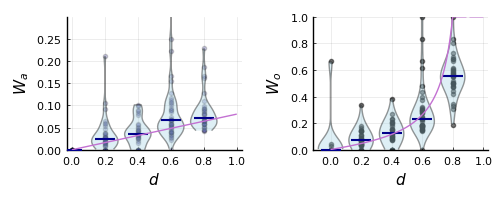

In [23]:
Nthresh_orph , Nthresh_estr = 500, 500
ds, Wa, Wo = get_turnover(tumorinfo; useknown_T = true, Nthresh_orph, Nthresh_estr,
    tumor_sample_func = df -> df)
mask = .!(isnan.(Wo))
ds, Wa, Wo = ds[mask], Wa[mask], Wo[mask]
plot_turnover_violin(ds, Wa, Wo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


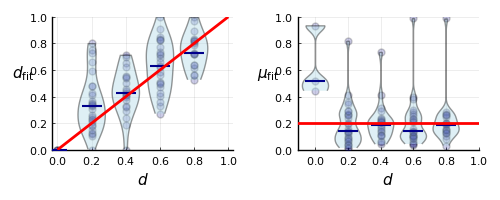

In [24]:
ds, dfits, mufits = infer_params( tumorinfo[mask,:]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo)
mask_fit = .!ismissing.(mufits)
plot_infresult_violin(ds[mask_fit], dfits[mask_fit], mufits[mask_fit]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:03:02


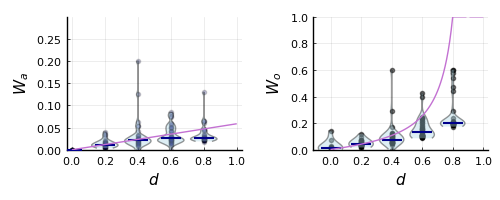

In [52]:
Nthresh_orph , Nthresh_estr = 5000, 5000
ds, Wa, Wo = get_turnover(tumorinfo; useknown_T = true, Nthresh_orph, Nthresh_estr,
    tumor_sample_func = df -> df)
mask = .!(isnan.(Wo))
ds, Wa, Wo = ds[mask], Wa[mask], Wo[mask]
plot_turnover_violin(ds, Wa, Wo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

# Spatial sampling

In [10]:
Nthresh_orph, Nthresh_estr, samplecutoff= 500, 500, 1/3
samplingparams = (n = 285, cells_per_sample = 20)

ds, Wa, Wo = get_turnover(tumorinfo; 
    useknown_N = false,
    useknown_T = false,
    Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr,
    tumor_sample_func = df -> begin
        samples, sampletumor = TumorGrowth.multi_region_sequencing(df; samplingparams...)
        for row in eachrow(sampletumor)
            mask = row.frequencies .> samplecutoff
            row.mutations, row.frequencies = row.mutations[mask], row.frequencies[mask]
        end
        sampletumor
    end,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,
#     subsample_func = df -> SeqDataFormatting.subsample(df; nmuts = 30, cols=[:mutations])
    
);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


In [77]:
scaleby = 1 / ( samplecutoff * samplingparams.n * samplingparams.cells_per_sample / 10_000 )

5.2631578947368425

### use samplefrequency

In [6]:
function infer_params_Ncorrect( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
    dfits = []
    mufits = []

    @showprogress for i in 1:nrow(tumorinfo)
        b, mu = tumorinfo.b[i], tumorinfo.μ[i]
        W_a, W_o = Wa[i], Wo[i]
        
        d_solve, mu_solve = 1., missing
        try
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; N= Nthresh_orph/(1-x) )) - W_a, 0.01, 0.99) * b
            mu_solve = fzero(x -> min(1., Turnover.W_estranged(d_solve; b=b, μ=x, 
                            T=log(Nthresh_estr* b/(b-d_solve)^2)))- W_o, 0.01, 0.99)
            catch e
        end

        push!(dfits, d_solve)
        push!(mufits, mu_solve)

        sleep(0.01)
    end
    return (ds = tumorinfo.d, dfits = dfits, mufits = mufits)
end

infer_params_Ncorrect (generic function with 1 method)

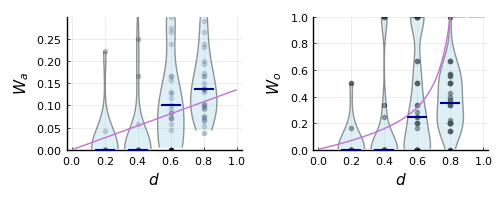

In [105]:
mask = @. !isnan(Wo) * !isnan(Wa)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


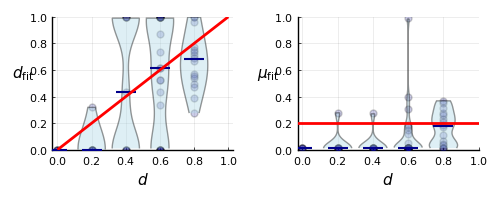

In [113]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

> Nthresh_orph, Nthresh_estr, samplecutoff= 40, 20, 1/2 <br>
> samplingparams = (n = 285, cells_per_sample = 20)

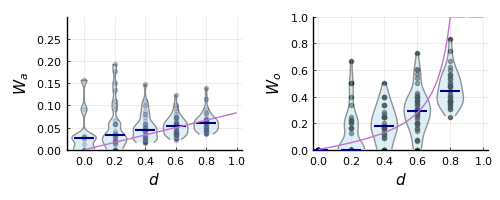

In [154]:
mask = @. !isnan(Wo) * !isnan(Wa)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


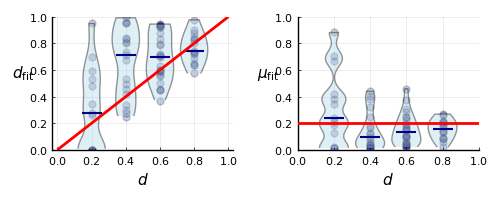

In [158]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph = Nthresh_orph_infer, Nthresh_estr = Nthresh_estr_infer, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

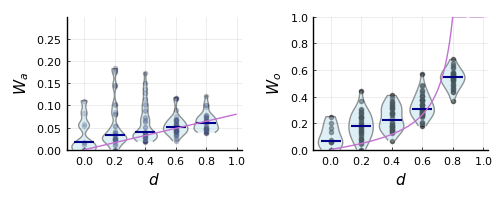

In [68]:
mask = @. !isnan(Wo) * !isnan(Wa)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


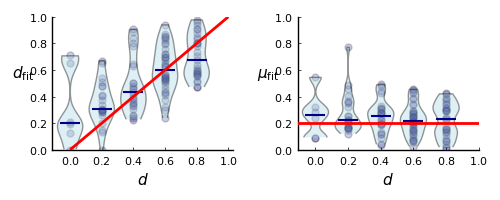

In [23]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200), grid=:off)

In [ ]:
# savefig(projectdir*"Turnover/turnover_plots/inference/inference_spatial_sampling_N500_n285_inference_violin.pdf")
# savefig(projectdir*"Turnover/turnover_plots/inference/inference_spatial_sampling_N500_n285_inference_violin.png")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


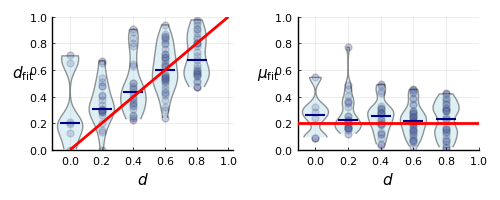

In [70]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


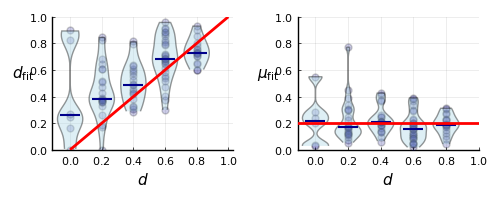

In [63]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph * scaleby, Nthresh_estr=Nthresh_estr *scaleby, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


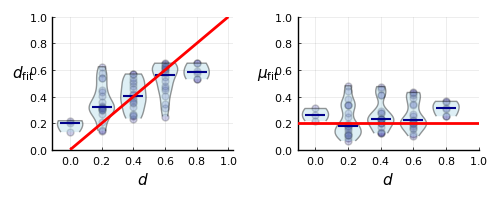

In [19]:
ds, dfits, mufits = infer_params_Ncorrect( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


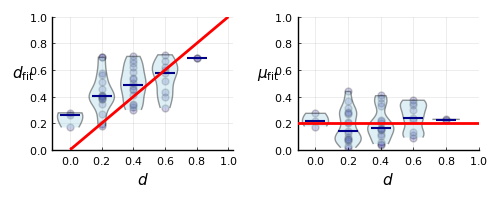

In [64]:
ds, dfits, mufits = infer_params_Ncorrect( tumorinfo; Nthresh_orph=Nthresh_orph * scaleby, Nthresh_estr=Nthresh_estr *scaleby, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

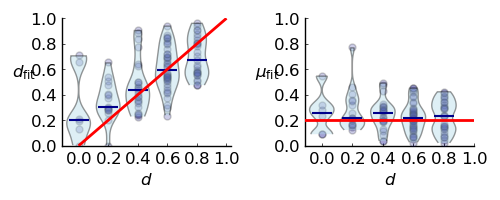

In [77]:
let data = include("turnover_data/inference_spatialdata_results.jl")[end]
    ds_, dfits_, mufits_ = data.ds, data.dfits, data.mufits
    mask = .!ismissing.(mufits_)
    plot_infresult_violin(ds_[mask], dfits_[mask], mufits_[mask]; mu=0.2, size=(500,200))
    plot!( size=(500,200), xlab=L"d", grid=false, guidefont = (12), tickfont = (12), legendfont=(12))
end

In [83]:
# savefig("Turnover/turnover_plots/inference/inference_spatial_N500_n285_mu_violin_defence.png")

> Nthresh_orph, Nthresh_estr, samplecutoff= 500, 500, 1/3 <br>
> samplingparams = (n = 285, cells_per_sample = 20)

### use known tumor size `N` at birth

In [78]:
function infer_params_Ncorrect( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
    dfits = []
    mufits = []

    @showprogress for i in 1:nrow(tumorinfo)
        b, mu = tumorinfo.b[i], tumorinfo.μ[i]
        W_a, W_o = Wa[i], Wo[i]
        
        d_solve, mu_solve = 1., missing
        try
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; N= Nthresh_orph*(1-x) )) - W_a, 0.01, 0.99) * b
            mu_solve = fzero(x -> min(1., Turnover.W_estranged(d_solve; b=b, μ=x, 
                            T=log(Nthresh_estr/b)))- W_o, 0.01, 0.99)
            catch e
        end

        push!(dfits, d_solve)
        push!(mufits, mu_solve)

        sleep(0.01)
    end
    return (ds = tumorinfo.d, dfits = dfits, mufits = mufits)
end

infer_params_Ncorrect (generic function with 1 method)

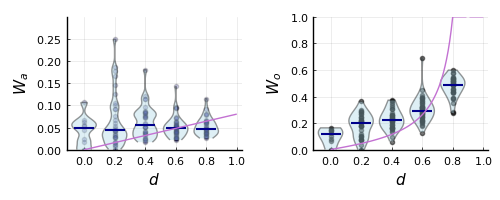

In [80]:
mask = @. !isnan(Wo) * !isnan(Wa)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


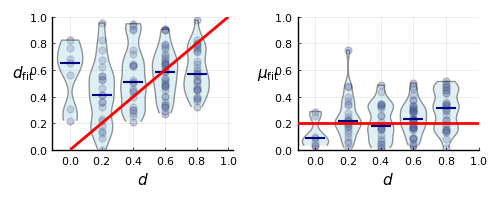

In [84]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo)
mask = [ !ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits, mufits)]
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


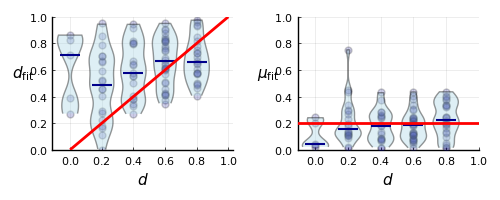

In [85]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph*scaleby, Nthresh_estr=Nthresh_estr*scaleby, Wa, Wo)
mask = [ !ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits, mufits)]
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


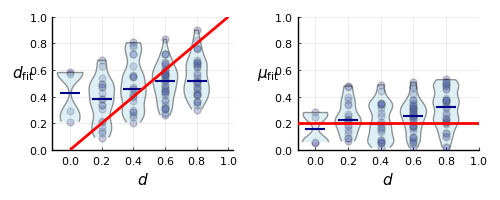

In [87]:
ds, dfits, mufits = infer_params_Ncorrect( tumorinfo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo)
mask = [ !ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits, mufits)]
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


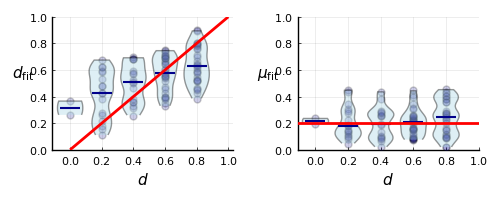

In [88]:
ds, dfits, mufits = infer_params_Ncorrect( tumorinfo; Nthresh_orph=Nthresh_orph*scaleby, Nthresh_estr=Nthresh_estr*scaleby, Wa, Wo)
mask = [ !ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits, mufits)]
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

### use known time `T` at birth

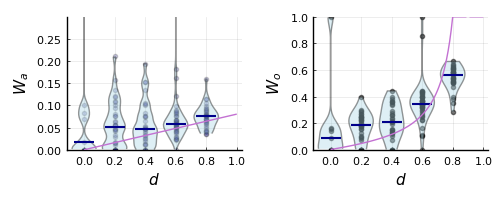

In [22]:
mask = .!isnan.(Wo)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


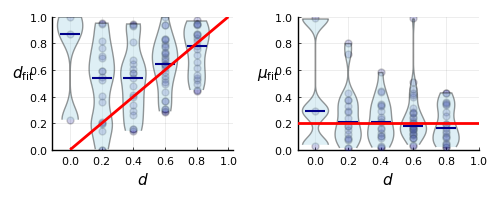

In [23]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
mask = [ !ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits, mufits)]
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

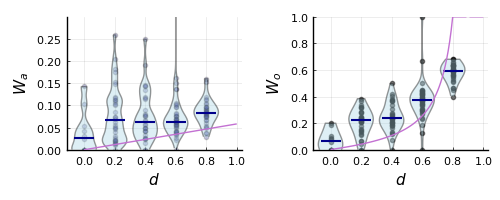

In [72]:
mask = .!isnan.(Wo)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


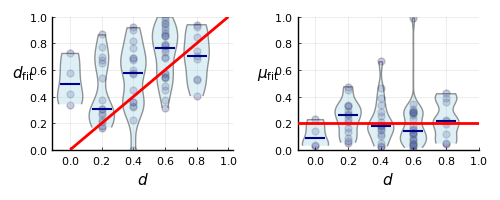

In [ ]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
mask = [ !ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits, mufits)]
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))